In [1]:
"""Metric Learning."""

import datetime
from ast import literal_eval
from types import MethodType

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import clear_output
from torch import nn, optim
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from playlist_selection.logging_config import get_logger

LOGGER = get_logger("root")
RANDOM_STATE = 42

In [2]:
session = boto3.Session(profile_name="project")
client = session.client("s3")

bucket = "hse-project-playlist-selection"
dataset_key = "dataset/filtered_data_30_11_23.csv"

body = client.get_object(Bucket=bucket, Key=dataset_key)["Body"]
df = pd.read_csv(body, index_col=0)

for column in "genres", "artist_name":
    df[column] = df[column].apply(literal_eval)

df.dropna(inplace=True)
df["album_release_date"] = pd.to_datetime(df["album_release_date"], format="mixed")
df = df.reset_index(drop=True)

df.head(1).T

2024-02-18 15:52:31,761 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-02-18 15:52:31,826 - botocore.configprovider - INFO - Found endpoint for s3 via: config_global.


,0
key,61_HighwayCorey_Harris
genre,acoustic
audio_path,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3
album_name,Between Midnight And Day
album_id,6fuRNpnOE7QgyT1IcdvpED
album_release_date,1995-10-31 00:00:00
artist_name,[Corey Harris]
artist_id,['1TQtbRQbaXw5CeN3mC0DJH']
track_id,3zGcBpopIzVBqqHRoRTCR2
track_name,61 Highway


# *Фичи

Для эксперимента возьмём просто числовые фичи из меты. Позже вместо них будем использовать эмбединги.

In [3]:
DROP_COLUMNS = [
    "diff_sec",
    "file_size_mb",
    "duration_ms",
]

def get_numeric_features(dataset: pd.DataFrame) -> list[str]:
    """Extract numeric features list from dataset."""
    idx = (dataset.select_dtypes(np.number).sample(50, random_state=RANDOM_STATE).nunique() == 50).index
    numeric_columns = dataset.loc[:, idx].select_dtypes(np.number).columns
    numeric_columns = numeric_columns.drop(labels=DROP_COLUMNS).tolist()
    return numeric_columns

numeric_features = get_numeric_features(df)
for numeric_feature in numeric_features:
    df[numeric_feature] = df[numeric_feature].astype(float)
df.loc[:, numeric_features].head(1)


,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,...,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_duration_ms
0,5.0,0.637,0.0229,-22.846,1.0,0.044,0.907,0.000145,0.226,80.923,...,4.0,780.0,0.318523,0.255563,1.0,0.0398,-5.691454,66.999615,-89.520079,288578.0


# Torch Dataset

In [4]:
pd.options.mode.chained_assignment = None

def get_positive_and_negative_objects(dataset: pd.DataFrame, anchor: pd.Series) -> tuple[int, int]:
    """Sample positive and negative object for anchor."""
    
    def get_intersection_score(other: list[str], anchor: list[str]) -> float:
        if len(anchor) == 0:
            return 0
        intersection = set(other) & set(anchor)
        score = len(intersection) / len(set(anchor))
        return score

    def get_realese_year_score(other: datetime.date, anchor: datetime.date):
        other = pd.to_datetime(other)
        anchor = pd.to_datetime(anchor)
        diff = abs(other.year - anchor.year) / 30 # ?
        return 1 - np.clip(diff, 0, 1)
    
    dataset = dataset.loc[dataset.index != anchor.name, :]

    genre_score = dataset["genre"] == anchor["genre"]
    artist_name_score = dataset["artist_name"].apply(get_intersection_score, args=(anchor["artist_name"], ))
    genres_score = dataset["genres"].apply(get_intersection_score, args=(anchor["genres"], ))
    album_release_date_score = dataset["album_release_date"].apply(
        get_realese_year_score, args=(anchor["album_release_date"], )
    )

    final_score = (
        0.5 * genre_score
        + 0.3 * genres_score
        + 0.15 * artist_name_score
        + 0.3 * album_release_date_score
    )

    dataset.loc[:, "final_score"] = final_score
    dataset = dataset.sort_values("final_score")
    positive_dataset = dataset.iloc[-50:, :]

    positive_track = positive_dataset.sample()
    negative_track = dataset.iloc[:len(dataset) // 2, :].sample()
    
    LOGGER.debug(
        "anchor - %s, positive - %s, negative - %s.",
        anchor["key"], positive_track["key"].iloc[0], negative_track["key"].iloc[0]
    )

    return positive_track.index[0], negative_track.index[0]


class AudioDataset(Dataset):
    """Dataset for audio features."""
    
    def __init__(self, df: pd.DataFrame):
        """DF - dataframe with audio metadata."""
        self.df = df
        
    def __len__(self) -> int:
        """Size of dataset."""
        return self.df.shape[0]
        
    def __getitem__(self, anchor_index: int) -> torch.tensor:
        """Index - id (?) of anchor track."""
        anchor_sample = self.df.iloc[anchor_index, :]
        positive_index, negative_index = get_positive_and_negative_objects(self.df, anchor_sample)
        
        anchor_sample = torch.from_numpy(anchor_sample.loc[numeric_features].to_numpy(dtype="float32"))
        positive_sample = torch.from_numpy(self.df.loc[positive_index, numeric_features].to_numpy(dtype="float32"))
        negative_sample = torch.from_numpy(self.df.loc[negative_index, numeric_features].to_numpy(dtype="float32"))

        return {
            "anchor": anchor_sample,
            "positive": positive_sample,
            "negative": negative_sample,
        }

In [5]:
def get_sample_by_artist(df: pd.DataFrame, artist_name: str, random_state: int | None = None) -> pd.Series:
    """Return sample for artist."""
    mask = df["artist_name"].apply(lambda x: any(y.lower() == artist_name.lower() for y in x))
    target_samples = df.loc[mask]
    if len(target_samples) == 0:
        LOGGER.warning("empty target samples for artist %s.", artist_name)
        return
    sample = target_samples.sample(1, random_state=random_state).iloc[0]
    return sample 

df.get_sample_by_artist = MethodType(get_sample_by_artist, df)
sample = df.get_sample_by_artist("Gunna", random_state=RANDOM_STATE)

n_samples_to_show = 5
for i in range(1, n_samples_to_show + 1):
    if sample is None:
        continue
    
    result = pd.concat([sample.to_frame().T, df.iloc[list(get_positive_and_negative_objects(df, sample))]])
    print("="*20, f"example {i}", "="*20)
    for label, (_, row) in zip(["anchor", "positive", "negative"], result.iterrows()):
        print(label, "-", row["track_name"], row["artist_name"], row["genres"])

==================== example 1 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - SRT (feat. BIG30 & Pooh Shiesty) ['Moneybagg Yo', 'BIG30', 'Pooh Shiesty'] ['memphis hip hop', 'rap', 'southern hip hop', 'tennessee hip hop', 'trap']
negative - Beyond Time - Club Mix ['Blank & Jones'] ['chill lounge', 'german techno', 'trance']
==================== example 2 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - No Flockin' ['Kodak Black'] ['florida drill', 'florida rap', 'melodic rap', 'miami hip hop', 'rap', 'trap', 'trap latino']
negative - Flux (Pariah) ['Lamb of God'] ['alternative metal', 'groove metal', 'melodic metalcore', 'metal', 'nu metal', 'virginia metal']
==================== example 3 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip h

# Модель

In [6]:
class Network(nn.Module):
    def __init__(self, input_size=len(numeric_features), embedding_size=256):
        super(Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_size)
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Пробуем что-то обучить

In [56]:
from sklearn.model_selection import train_test_split


BATCH_SIZE = 64
EMBEDDING_SIZE = 256
LR = 0.001
MARGIN = 3

train_df, val_df = train_test_split(df, test_size=0.4, stratify=df["genre"], random_state=RANDOM_STATE)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = AudioDataset(df=train_df)
val_dataset = AudioDataset(df=val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

model = Network(input_size=len(numeric_features), embedding_size=EMBEDDING_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = TripletMarginLoss(margin=MARGIN)

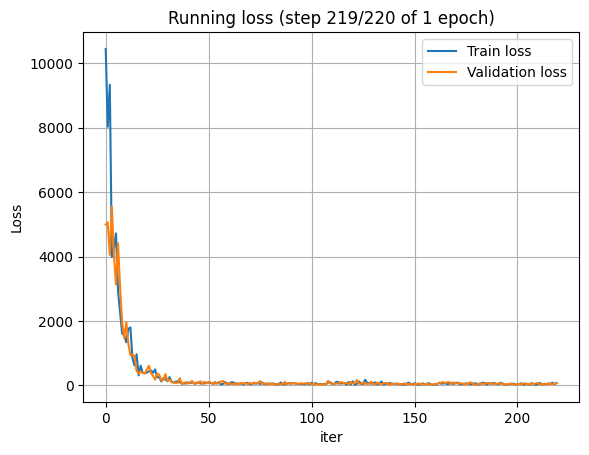

2024-02-18 18:36:00,264 - root - INFO - Epoch: 1/1 - Loss: 332.6005847757513


In [57]:
PLOT = True
DEVICE = "cpu"
EPOCHS = 1

model.train()
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    val_running_loss = []
    for step, objects in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        
        optimizer.zero_grad()
        anchor_out = model(objects["anchor"])
        positive_out = model(objects["positive"])
        negative_out = model(objects["negative"])
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy().tolist())
        
        with torch.no_grad():
            model.eval()
            val_objects = next(iter(val_loader))

            val_anchor_out = model(val_objects["anchor"])
            val_positive_out = model(val_objects["positive"])
            val_negative_out = model(val_objects["negative"])

            val_loss = criterion(val_anchor_out, val_positive_out, val_negative_out)
            val_running_loss.append(val_loss.cpu().detach().numpy().tolist())
            model.train()
        
        if PLOT:
            clear_output(wait=True)
            fig, ax = plt.subplots(1, 1)
            sns.lineplot(x=range(len(running_loss)), y=running_loss, ax=ax, label="Train loss")
            sns.lineplot(x=range(len(val_running_loss)), y=val_running_loss, ax=ax, label="Validation loss")
            ax.grid(True)
            ax.legend()
            ax.set_xlabel("iter")
            ax.set_ylabel("Loss")
            ax.set_title(f"Running loss (step {step}/{len(train_loader)} of {epoch + 1} epoch)")
            plt.show()

    LOGGER.info("Epoch: %s/%s - Loss: %s", epoch+1, EPOCHS, np.mean(running_loss))

### Примеры

In [58]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

model.eval()

val_df.get_sample_by_artist = MethodType(get_sample_by_artist, val_df)
sample = val_df.get_sample_by_artist("Playboi Carti", random_state=RANDOM_STATE)

n_samples_to_show = 5
for i in range(1, n_samples_to_show + 1):
    if sample is None:
        continue
    
    objects = df.iloc[list(get_positive_and_negative_objects(df, sample))]
    result = pd.concat([sample.to_frame().T, objects])
    
    embedding = model(torch.from_numpy(result[numeric_features].to_numpy(dtype="float32")))

    cosine_sim = cosine_similarity(embedding.detach().numpy()).tolist()
    euclidian_diff = pairwise_distances(embedding.detach().numpy()).tolist()

    print("="*20, f"example {i}", "="*20)
    i = 0
    for label, (_, row) in zip(["anchor", "positive", "negative"], result.iterrows()):
        print(label, "-", row["track_name"], row["artist_name"][:3], row["genres"][:3], f"cosine_sim - {round(cosine_sim[0][i], 3)}", f"euclidian - {round(euclidian_diff[0][i], 3)}")
        i = i + 1

==================== example 1 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - Freak Hoe ['Future'] ['atl hip hop', 'hip hop', 'rap'] cosine_sim - 0.983 euclidian - 111.824
negative - Fake Palindromes ['Andrew Bird'] ['baroque pop', 'chamber pop', 'chicago indie'] cosine_sim - 0.975 euclidian - 80.972
==================== example 2 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - Know Yourself ['Drake'] ['canadian hip hop', 'canadian pop', 'hip hop'] cosine_sim - 0.976 euclidian - 235.225
negative - Supadupafly - On Air Edit ['666'] ['eurodance', 'german techno'] cosine_sim - 0.984 euclidian - 190.861
==================== example 3 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - The Thrill ['Wiz Khalifa', 'Empire of the Sun'

# TODO:

* более умная валидация (+ наши метрики)
* PML
* arcface loss?
* другие подходы